In [1]:
import sys
import os
os.chdir("..")
sys.path.append(".")

In [7]:
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.metrics import classification_report, accuracy_score

from src.data.dataloader import get_data_loaders
from src.utils.model_loader import load_ensemble
from src.utils.visualization import plot_confusion, plot_dashboard
import config

In [3]:
_, test_loader, _, _ = get_data_loaders()
ensemble = load_ensemble(config.NUM_MODELS, config.NUM_CLASSES, config.DEVICE)

print("""
███████╗██╗   ██╗ █████╗ ██╗        ███████╗████████╗ █████╗ ██████╗ ████████╗
██╔════╝██║   ██║██╔══██╗██║        ██╔════╝╚══██╔══╝██╔══██╗██╔══██╗╚══██╔══╝
█████╗  ██║   ██║███████║██║        ███████╗   ██║   ███████║██████╔╝   ██║   
██╔══╝  ╚██╗ ██╔╝██╔══██║██║        ╚════██║   ██║   ██╔══██║██╔══██╗   ██║   
███████╗ ╚████╔╝ ██║  ██║███████╗   ███████║   ██║   ██║  ██║██║  ██║   ██║   
╚══════╝  ╚═══╝  ╚═╝  ╚═╝╚══════╝   ╚══════╝   ╚═╝   ╚═╝  ╚═╝╚═╝  ╚═╝   ╚═╝   
    ░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░      
""")

Loaded 10 models from ./saved_models

███████╗██╗   ██╗ █████╗ ██╗        ███████╗████████╗ █████╗ ██████╗ ████████╗
██╔════╝██║   ██║██╔══██╗██║        ██╔════╝╚══██╔══╝██╔══██╗██╔══██╗╚══██╔══╝
█████╗  ██║   ██║███████║██║        ███████╗   ██║   ███████║██████╔╝   ██║   
██╔══╝  ╚██╗ ██╔╝██╔══██║██║        ╚════██║   ██║   ██╔══██║██╔══██╗   ██║   
███████╗ ╚████╔╝ ██║  ██║███████╗   ███████║   ██║   ██║  ██║██║  ██║   ██║   
╚══════╝  ╚═══╝  ╚═╝  ╚═╝╚══════╝   ╚══════╝   ╚═╝   ╚═╝  ╚═╝╚═╝  ╚═╝   ╚═╝   
    ░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░      



In [4]:
y_true, y_pred = [], []
all_conf = []

for x, y in test_loader:
    x = x.to(config.DEVICE)
    probs_list = []
    
    for model_i in ensemble:
        model_i.eval()
        with torch.no_grad():
            logits = model_i(x)
            probs = F.softmax(logits, dim=1)
            probs_list.append(probs)
    
    probs_stack = torch.stack(probs_list)
    mean_probs = probs_stack.mean(dim=0)
    confs, preds = mean_probs.max(dim=1)

    preds_np = preds.cpu().numpy()
    y_np = y.numpy()
    confs_np = confs.cpu().numpy()

    y_true.extend(y_np)
    y_pred.extend(preds_np)
    all_conf.extend(confs_np)

In [5]:
print("Accuracy:", accuracy_score(y_true, y_pred))

print(
    "\nClassification Report:\n",
    classification_report(y_true, y_pred, target_names=config.CLASS_NAMES)
)

Accuracy: 0.996186117467582

Classification Report:
               precision    recall  f1-score   support

      Glioma       1.00      0.99      0.99       300
  Meningioma       0.98      1.00      0.99       306
    No Tumor       1.00      1.00      1.00       405
   Pituitary       1.00      1.00      1.00       300

    accuracy                           1.00      1311
   macro avg       1.00      1.00      1.00      1311
weighted avg       1.00      1.00      1.00      1311



Confusion Matrix:
[[296   4   0   0]
 [  0 306   0   0]
 [  0   0 405   0]
 [  0   1   0 299]]

Plot saved to ./saved_eval_plots/confusion_matrix.png


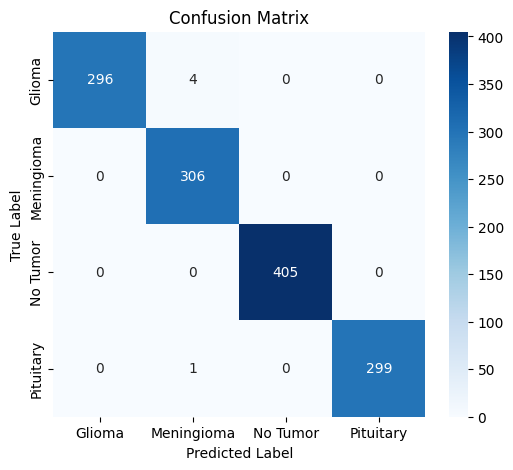

In [6]:
plot_confusion(y_true, y_pred, config.CLASS_NAMES)

Plot saved to ./saved_eval_plots/confidence_analysis_dashboard.png


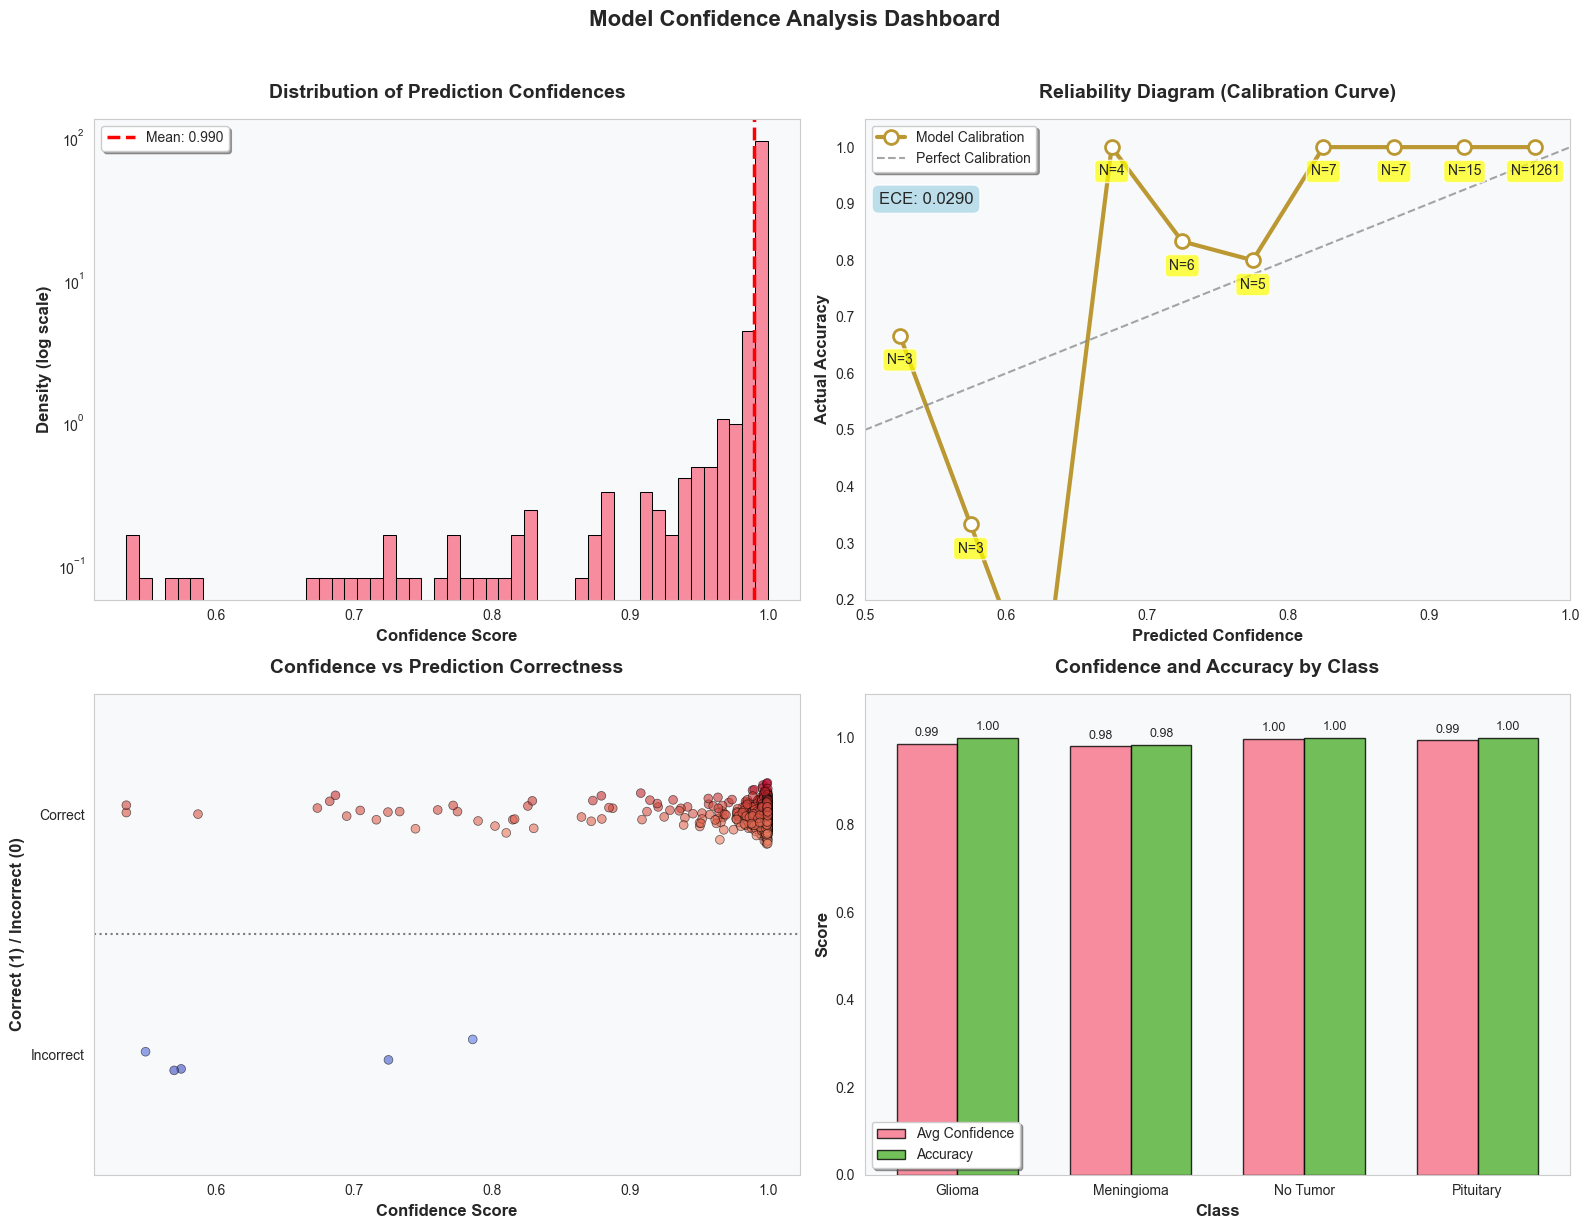

In [8]:
all_conf = np.array(all_conf)
y_true = np.array(y_true)
y_pred = np.array(y_pred)
correct = (y_pred == y_true)

plot_dashboard(all_conf, correct, y_true, y_pred)